<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Modelos avanzados de minería de datos · PEC1</p>
<p style="margin: 0; text-align:right;">2020-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación

 </p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Preparación de datos

A lo largo de esta práctica veremos como aplicar diferentes tecnicas para la carga y preparación de datos:

 <ol start="1">
  <li>Carga de un conjunto de datos</li>
  <li>Análisis de los datos
  <br>2.1 Análisis estadístico básico
  <br>2.2 Análisis expxloratorio de los datos
  <li>Reducción de la dimensionalidad</li>
  <li>Entrenamiento y test</li>
</ol>
   
Para eso necesitaremos las siguientes librerías:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

%matplotlib inline

# 1. Carga del conjunto de datos (1 punto)

En primer lugar, debéis cargar el conjunto de datos "Boston house prices", el cual contiene el valor de las casas en diferentes zonas de Boston dependiendo de múltiples factores. Se puede descargar de internet [aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/) o se puede cargar directamente desde la librería "scikit-learn", que incorpora un conjunto de datasets muy conocidos y usados para la minería de datos y machine learning [http://scikit-learn.org/stable/datasets/index.html](http://scikit-learn.org/stable/datasets/index.html).

Para los ejercicios de esta PEC, utilizaremos como variable respuesta a "MEDV": la mediana del valor de las casas en una zona de Boston (en k$).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Cargad el conjunto de datos "boston house-prices dataset" y mostrad:
<ul>
  <li>el número y nombre de los atributos (variables que podrían ser usadas para predecir la respuesta "MEDV")</li>
  <li>el número de filas del conjunto de datos</li>
  <li>verificad si hay o no "missing values" y en qué columnas</li>
</ul>

<hr>
Sugerencia: Si usáis sklearn (sklearn.datasets.load_boston), explorad las diferents 'keys' del objecto obtenido.<br>
Sugerencia: Igual os resulta útil pasar los datos (atributos + respuesta) a un dataframe de pandas.
</div>

## Respuesta

Comenzamos por cargar el dataset en una variable que después nos servirá para crear el dataframe de pandas y para acceder al atributo DESCR de load_boston, que nos da una descripción de los atributos del dataset.

La carga de los datos a un df de pandas se ha hecho dando un pequeño rodeo. En lugar de cargar directamente al dataframe, hemos extraído los atributos y el target por separado para después concatenarlos con pandas. Se ha hecho por si posteriormente fuera práctico tener target y atributos separados para la separación del conjunto de datos en entrenamiento, test y validación.

In [2]:
boston = datasets.load_boston()
boston_columns = pd.DataFrame(boston.data,
                         columns= boston['feature_names'])
boston_target = pd.DataFrame(boston.target, columns=["MEDV"])
boston_pd = pd.DataFrame(pd.concat([boston_columns, boston_target], axis=1))

print(boston.DESCR)


.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

En la descripción del conjunto de datos podemos ver claramente cómo este se compone por 506 instancias, 13 atributos y un 14º que suele funcionar como target. 

En cuanto a los atributos que nos pueden servir de descriptores, lo más fácil para comprobarlo es visualizar las correlaciones entre los distintos atributos, para lo que podemos crear una matriz de correlaciones.

Text(0.5, 1.0, 'Matriz de correlación para el dataset boston de scikit')

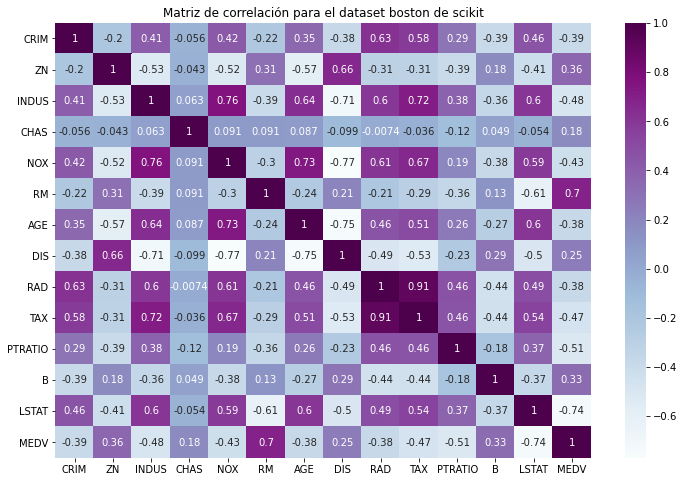

In [3]:
# Vamos a comenzar por cambiar el tamaño de las gráficas por defecto del notebook para mejorar la visualización

plt.rcParams['figure.figsize'] = [12, 8]

# La matriz de correlación la creamos con el atributo corr() y la visualización con un simple mapa de calor de seaborn 
boston_corr_matrix = boston_pd.corr()
sns.heatmap(boston_corr_matrix, annot=True, cmap="BuPu")
plt.title("Matriz de correlación para el dataset boston de scikit")

Con esto podemos decir que los más útiles serán RM (número de habitaciones medio), INDUS (proporción de industria en el área), TAX (tasa de impuesto sobre la propiedad)  y LSTAT (Porcentaje de población de clase baja).

Por último, vamos a comprobar si hay o no missing values utilizando el atributo de nuestro df de pandas isnull() y sumando las ocurrencias verdaderas.

In [4]:
boston_pd.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Ninguna de las columnas contiene elementos en blanco o nulos.

# 2. Análisis de los datos (3 puntos)

## 2.1 Análisis estadístico básico

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Realizad un análisis estadístico básico: 
<br>

<ul>
  <li>Variables categóricas:</li>
     <ul>
      <li>Calculad la frecuencia</li>
      <li>Haced un gráfico de barras</li>
    </ul>
  <li>Variables numéricas:</li>
    <ul>
      <li>Calculad estadísticos descriptivos básicos: media, mediana, desviación estandard, ...</li>
      <li>Haced un histograma de las variables INDUS, AGE y MEDV</li>
    </ul>
</ul>
    
<hr>
Sugerencia: podéis usar la librería 'pandas' y sus funciones 'describe' y 'value_counts', así como las funciones 'bar' e 'hist' de matplotlib.
</div>

Recordando lo que hemos visto en el ejercicio anterior, podemos considerar como categórico el atributo CHAS (Charles River dummy variable).

#### Variables categóricas

El proceso va a ser el que sigue: calcular la frecuencia del atributo en un objeto series de pandas, graficar con matplotlib índices y valores (es decir el atributo height) por separado y nombrar las etiquetas.

Text(0.5, 1.0, 'Número de extensiones limítrofes con el río')

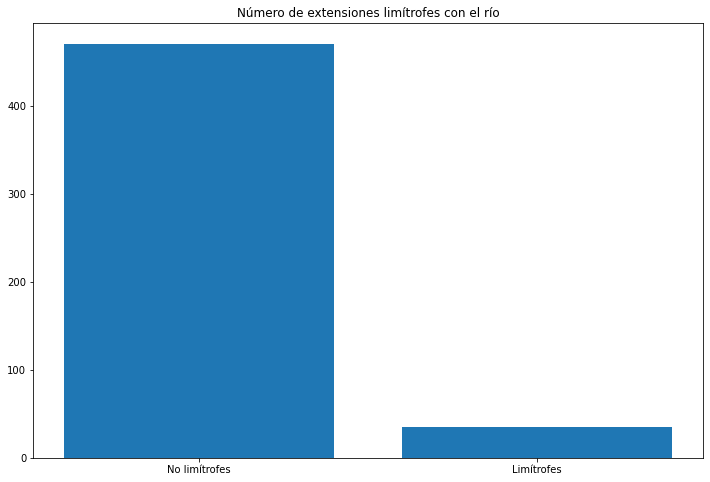

In [5]:
boston_count_chas = boston_pd["CHAS"].value_counts()

# Sustituimos los valores del conteo por unos más descriptivos y graficamos los resultados.
boston_count_chas.index = "No limítrofes", "Limítrofes"
plt.bar(boston_count_chas.index, boston_count_chas.values)
plt.title("Número de extensiones limítrofes con el río")


In [6]:
# Por último podemos imprimir en pantalla los valores que han sido graficados para ver el valor exacto

print(boston_count_chas)

No limítrofes    471
Limítrofes        35
Name: CHAS, dtype: int64


#### Variables numéricas

Primero vemos los valores descriptivos estadísticos utilizando describe() sobre todas las columnas excepto las categóricas.

In [7]:
boston_pd.drop(["CHAS"], axis = 1).describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Los histogramas se crean con plt.hist(), como recomendado en el enunciado. 
Cada una de las tres gráficas sigue el siguiente patrón de código: Abrir figura, graficar, titular y mostrar. Los bins están establecidos en 30 para mejorar la visualización después de haber hecho varias pruebas. 

<ipython-input-8-20c15c82b068>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  indus_plt.show()
<ipython-input-8-20c15c82b068>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  indus_plt.show()
<ipython-input-8-20c15c82b068>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  medv_plt.show()


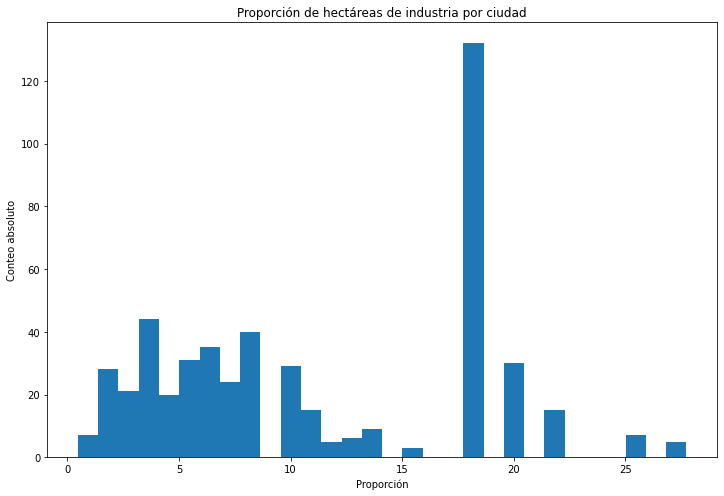

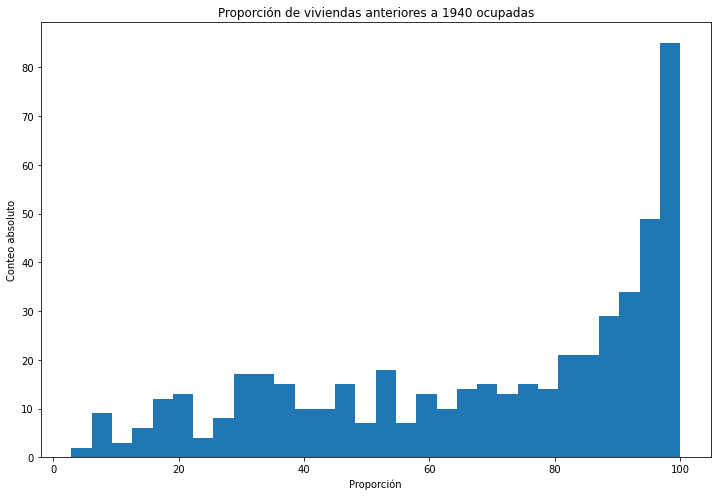

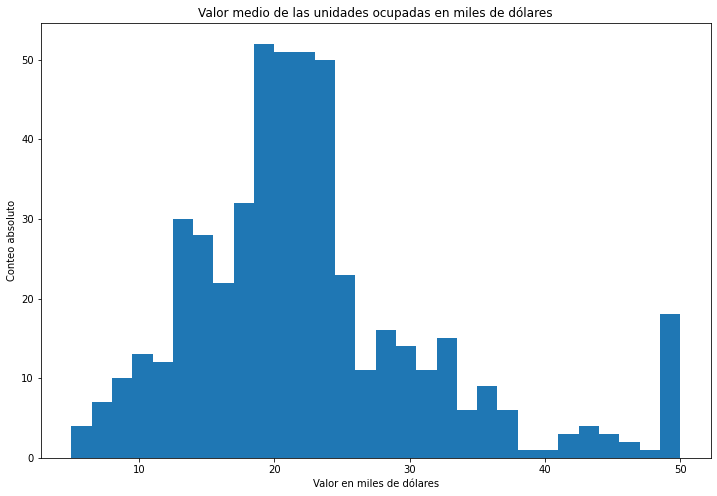

In [8]:
# INDUS
indus_plt = plt.figure(0)
plt.hist(boston_pd["INDUS"], bins = 30)
plt.title("Proporción de hectáreas de industria por ciudad")
plt.xlabel("Proporción")
plt.ylabel("Conteo absoluto")
indus_plt.show()

# AGE
age_plt = plt.figure(1)
plt.hist(boston_pd["AGE"], bins = 30)
plt.title("Proporción de viviendas anteriores a 1940 ocupadas")
plt.xlabel("Proporción")
plt.ylabel("Conteo absoluto")
indus_plt.show()

# MEDV
medv_plt = plt.figure(2)
plt.hist(boston_pd["MEDV"], bins = 30)
plt.title("Valor medio de las unidades ocupadas en miles de dólares")
plt.ylabel("Conteo absoluto")
plt.xlabel("Valor en miles de dólares")
medv_plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong><br>
Comentad los resultados.
</div>

Las distribuciones en todas las imágenes son razonablemente normales salvo dos excepciones: las ciudades con un 18% de terreno industrial y las ciudades que presentan un valor mediano de 50000 dólares. En este punto no encontramos ningún que nos permita relacionar estas dos anomalías en las distribuciones y la lógica parece decirnos que no debe existir tal relación. No podemos olvidar tampoco que la correlación entre estos dos atributos era de -0.48, una cifra poco significativa.

En cambio sí que pudimos ver una correlación de 0,64 entre el suelo industrial y el porcentaje de viviendas anteriores a 1940 ocupadas, el cuál a primera vista no se puede observar en estos resultados, pero para lo que podría ser muy interesante continuar indagando en el resto de atributos de aquellas ciudades con un 18% o más de su suelo ocupado por actividades industriales.

## 2.2 Análisis exploratorio de los datos

En este ejercicio exploraremos la relación de los atributos con la variable respuesta, mediante gráficos y analizando las correlaciones de los atributos numéricos.

In [9]:
response = "MEDV"
cat_feat = "CHAS"
num_feats = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
print('Respuesta ("target"):', response)
print("Atributo categórico:", cat_feat)
print("Atributos numéricos:", num_feats)

Respuesta ("target"): MEDV
Atributo categórico: CHAS
Atributos numéricos: ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Realizad un gráfico del histograma de valores de la variable respuesta, separado por los posibles valores (clases) del atributo categórico. Para comparar mejor los valores de MEDV para las diferentes clases de CHAS, los histogramas del gráfico tienen que estar sobrepuestos. Añadid una leyenda para saber a qué clase corresponde cada histograma.
    
La finalidad es observar como se distribuye el valor de la respuesta MEDV en función del valor de la clase CHAS, para poder identificar de manera visual y rápida si este atributo categórico está relacionado con diferentes valores de la respuesta.
    
<hr>
Sugerencia: podéis usar la función "hist" de la librería "matplotlib", así como su parámetro "alpha" para que se aprecien los histogramas sobrepuestos.<br>
Sugerencia: para comparar mejor los histogramas, considerad representar la densidad de probabilidad en vez del número de entradas por bin. De este modo, la escala de los histogramas será la misma para cada clase y será fácil de comparar. Podéis usar el parámetro "density" de la misma función "hist".  
</div>

Una cualidad de pyplotlib a la hora de crear las gráficas, es que estas deberían ser abiertas y cerradas, al no hacerlo, podemos observar la superposición de dos parámetros o variables distintos, en nuestro caso, los histogramas de los valores medianos en relación con la variable categórica CHAS.

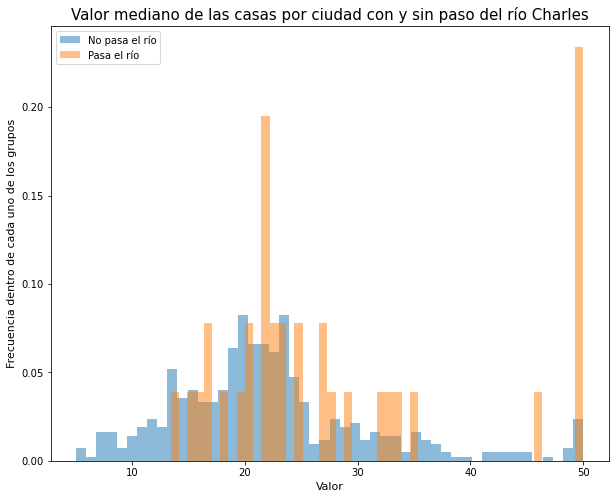

In [10]:
# Volvemos a cambiar el tamaño de la figura para facilitar su lectura.
plt.figure(figsize=(10,8))

# Graficamos los dos histogramas con una transparencia de 0.5 y 50 bins. Aceptamos el consejo de generar los resultados
# en una gráfica de densidad para extraer conclusiones más facilmente.
plt.hist(boston_pd["MEDV"].loc[boston_pd["CHAS"] == 0], bins = 50, alpha = 0.5, label = "No pasa el río", density = True)
plt.hist(boston_pd["MEDV"].loc[boston_pd["CHAS"] == 1], bins = 50, alpha = 0.5, label = "Pasa el río", density = True)

# Generamos las etiquetas explicativas y situamos la leyenda en el lugar más libre de nuestra gráfica.
plt.xlabel("Valor", size = 11)
plt.ylabel("Frecuencia dentro de cada uno de los grupos", size = 11)
plt.title("Valor mediano de las casas por ciudad con y sin paso del río Charles", size = 15)
plt.legend(loc = 'upper left')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
<br> Mirando los histogramas, ¿te parece que el atributo CHAS tendrá algún peso a la hora de predecir la mediana del precio de las casas, MEDV? ¿Porqué? 
</div>

Sí, el grueso de viviendas en cada una de las zonas parece bastante determinado en función del paso del río Charles. En el grupo de instancias en el que no pasa, vemos una agrupación en los valores bajos del eje x (valor de las viviendas), por el contrario, la distribución de los casos positivos no tiene valores por debajo de 15000 dólares y sí que tiene casi un 25% de las  apariciones en el extremo de 50000.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Repetid los histogramas anteriores, añadiendo una línea vertical indicando la media de cada uno de los histogramas. Pintad las linias del mismo color que el histograma para que quede claro a cual hacen referencia. Añadid a la leyenda la clase de CHAS y los valores de la media y la desviación estandard en cuestión. La finalidad es verificar numéricamente las diferencias identificadas anteriormente de forma visual.
    
<hr>
Sugerencia: podeis usar "axvline", de matplotlib axis, para las linias verticales.
</div>

Al ser una repetición, el código es tremendamente parecido. En este caso vamos a controlar los colores y a añadir las líneas verticales para las medias. Estas se han añadido siendo calculadas previamente para facilitar su inclusión en la leyenda.

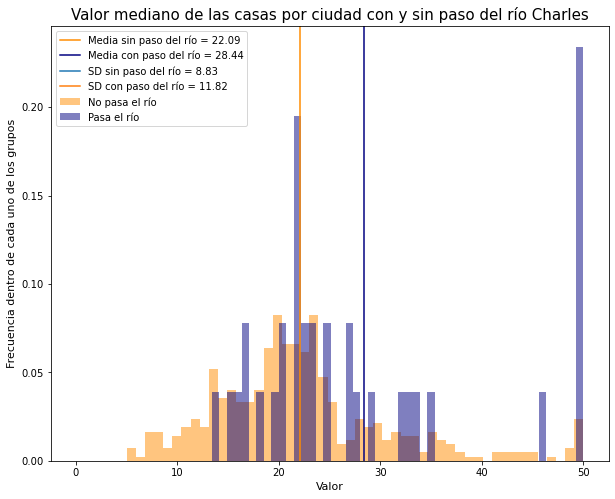

In [11]:
# Creación de las gráficas como en el ejemplo anterior.
plt.figure(figsize=(10,8))
plt.hist(boston_pd["MEDV"].loc[boston_pd["CHAS"] == 0], bins = 50, alpha = 0.5, 
         label = "No pasa el río", density = True, color = "darkorange")
plt.hist(boston_pd["MEDV"].loc[boston_pd["CHAS"] == 1], bins = 50, alpha = 0.5, 
         label = "Pasa el río", density = True, color = "Navy")

# Cálculo de las medias y las desviaciones estándar.
medv_0_mean = boston_pd["MEDV"].loc[boston_pd["CHAS"] == 0].mean()
medv_1_mean = boston_pd["MEDV"].loc[boston_pd["CHAS"] == 1].mean()
medv_0_std = boston_pd["MEDV"].loc[boston_pd["CHAS"] == 0].std()
medv_1_std = boston_pd["MEDV"].loc[boston_pd["CHAS"] == 1].std()

# Dibujamos las medias y las incluimos en la leyenda. La inclusión de las desviaciones estándar en la leyenda se ha hecho
# dibujando un punto falso y aprovechando el argumento label para que se añada un hipótetico valor.
plt.axvline(medv_0_mean, color = "darkorange", 
            label = "Media sin paso del río = {:.2f}".format(medv_0_mean))
plt.axvline(boston_pd["MEDV"].loc[boston_pd["CHAS"] == 1].mean(), color = "Navy", 
            label = "Media con paso del río = {:.2f}".format(medv_1_mean))
plt.plot(0, 0, label = "SD sin paso del río = {:.2f}".format(medv_0_std))
plt.plot(0, 0, label = "SD con paso del río = {:.2f}".format(medv_1_std))

# Definimos el resto de etiquetas y mostramos la leyenda.
plt.xlabel("Valor", size = 11)
plt.ylabel("Frecuencia dentro de cada uno de los grupos", size = 11)
plt.title("Valor mediano de las casas por ciudad con y sin paso del río Charles", size = 15)
plt.legend(loc = 'upper left')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Calculad y mostrad la correlación entre todos los atributos numéricos y la respuesta.
</div>

Text(0.5, 1.0, 'Matriz de correlación para el dataset boston de scikit sin el atributo CHAS')

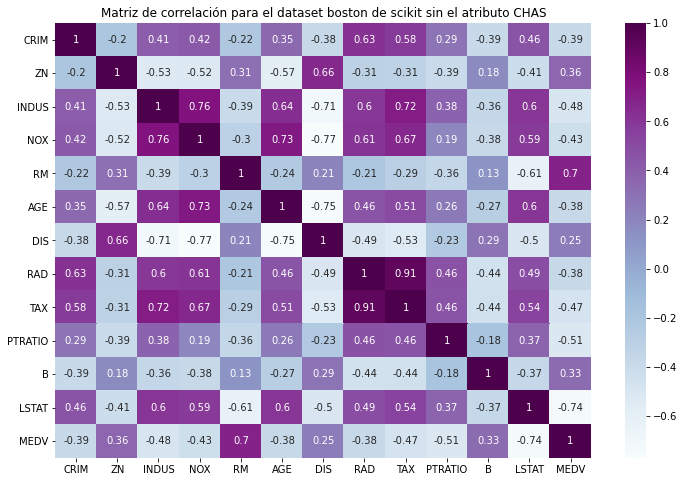

In [12]:
# Ya lo hicimos anteriormente así que me limito a copiar y pegar el código eliminando la columna categórica

boston_corr_matrix = boston_pd.drop(["CHAS"], axis = 1).corr()
sns.heatmap(boston_corr_matrix, annot=True, cmap="BuPu")
plt.title("Matriz de correlación para el dataset boston de scikit sin el atributo CHAS")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Identificad los 2 atributos que tienen una correlación más fuerte con la respuesta y los 2 con una correlación más débil (coeficiente de correlación mayor o menor en valor absoluto).
    
Para observar y analizar las correlaciones gráficamente, representad, para cada uno de los 4 atributos identificados, un scatter plot con el atributo en el eje x y la respuesta en el eje y. Además, en cada gráfico añadid la representación de una regresión lineal que fite los puntos.
        
<hr>Sugerencia: podéis usar la función "regplot" de la librería 'seaborn'.
</div>

Este caso es bastante sencillo, basta con seleccionar una columna y elegir sus dos valores más grandes y sus dos más pequeños gracias a los atributos nlargest(n) y nsmallest(n).

In [144]:
print(boston_corr_matrix["MEDV"].nlargest(3)) # n = 3 es la forma más sencilla de contrarrestar el cruce con el propio atributo
print(boston_corr_matrix["MEDV"].nsmallest(2))

MEDV    1.000000
RM      0.695360
ZN      0.360445
Name: MEDV, dtype: float64
LSTAT     -0.737663
PTRATIO   -0.507787
Name: MEDV, dtype: float64


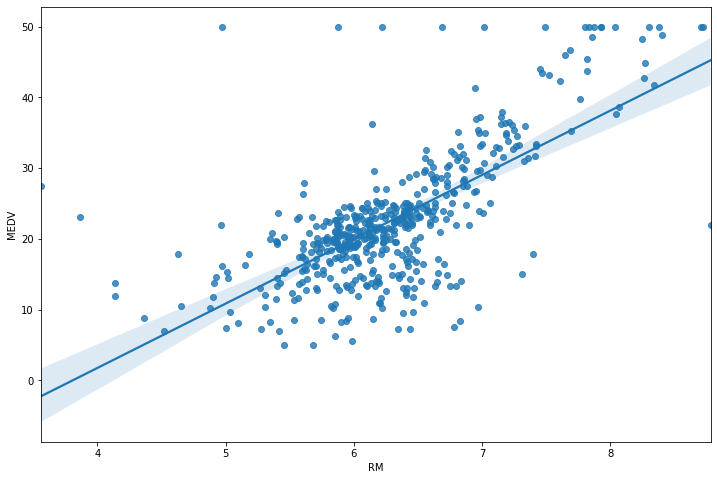

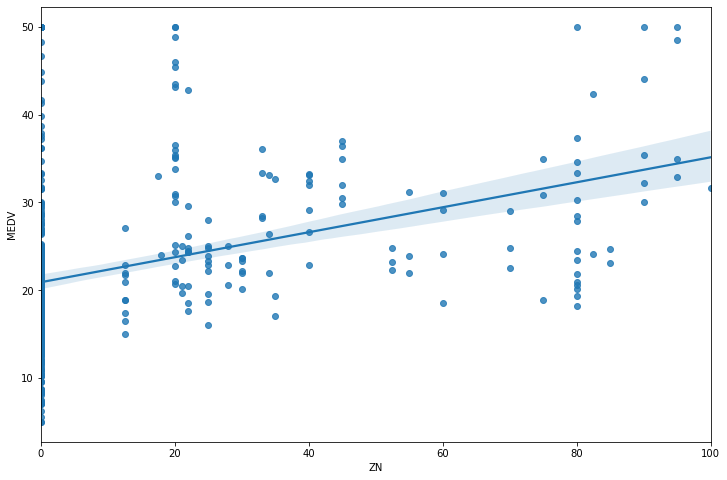

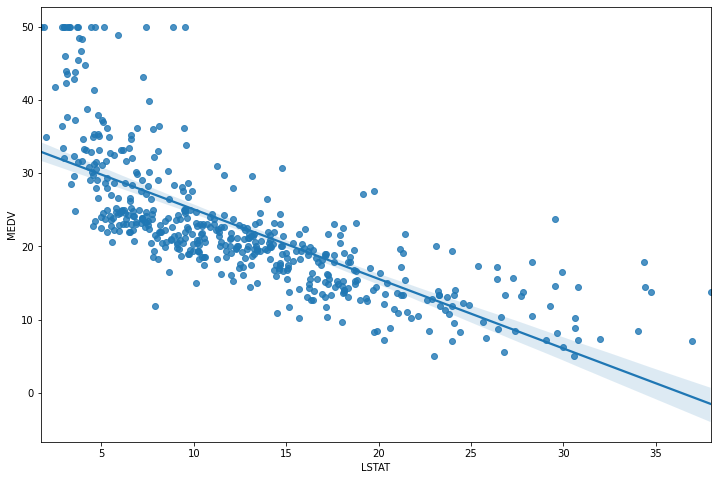

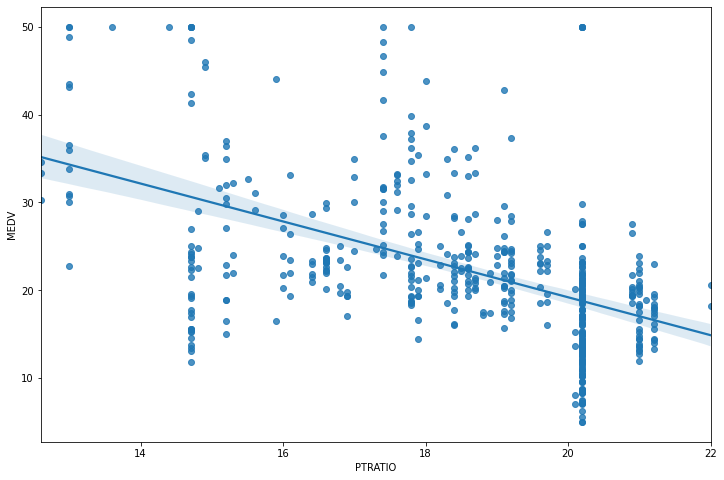

In [155]:
for i, atribute in enumerate(boston_pd[["RM", "ZN", "LSTAT", "PTRATIO"]]):
    plt.figure(i)
    sns.regplot(x = atribute, y = "MEDV", data = boston_pd[[atribute, "MEDV"]])
    plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
<br> Observando los gráficos, comentad brevemente si conseguís ver las altas o bajas correlaciones que habíais identificado numéricamente.
</div>

Sí, es bastante claro que las correlaciones entre MEDV y RM y LSTAT son mayores a las mostradas con los otros dos atributos.

El primer punto es bastante evidente, el de que el orden ascendente de los valores y por tanto de la regresión indican una correlación positiva, mientras que la descendente una negativa.

Segundo, podemos observar que en aquellas correlaciones de mayor valor absoluto, las instancias se encuentran mucho más cerca de la línea de regresión. Claramente, en ZN y PRATIO, esto sucede en mucha menor medida.

Por último, la concentración de los valores no cercanos a la línea de regresión es mucho mayor en los ejemplos con correlaciones altas que en aquellos con correlaciones bajas, lo cual nos lleva a deducir que la dispersión generalizada (por llamarlo de alguna forma) de los valores de cada atributo respecto al valor de MEDV, perjudica al valor de la correlación.

# 3. Reducción de la dimensionalidad (2 puntos)

En este ejercicio se aplicarán métodos de reducción de la dimensionalidad al conjunto original de datos. El objetivo es reducir el conjunto de atributos a un nuevo conjunto con menos dimensiones, pero que contengan la máxima información posible presente en los atributos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
<ul>
    <li>Aplicad el método de reducción de la dimensionalidad Principal Component Analysis (PCA) para reducir a 2 dimensiones el dataset original que contiene todos los atributos.</li>
    <li>Generad un gráfico con el resultado del PCA en el que se muestre, en función de los valores de las dos componentes en los ejes x e y, el valor de la respuesta MEDV usando la escala de colores. El objetivo es visualizar la variación de MEDV en función de los valores de las componentes principales generadas.</li>
</ul>
    
NOTA: Vigilad de no incluir la variable objetivo "MEDV" en la reducción de dimensionalidad. Queremos poder explicar la variable objetivo en función del resto de variables reducidas a dos dimensiones.

<hr>
Sugerencia: no es necesario que programéis el algoritmo de PCA, podéis usar la implementación disponible en la librería de "scikit-learn".<br>
Sugerencia: para el gráfico, podéis usar el scatter plot de matplotlib con el parámetro "c", que indica el color de los puntos, igual a la variable objetivo.
</div>

Antes de aplicar una reducción dimensional es indispensable que estandaricemos los valores para no dar excesivo peso a alguno de los atributos. Además, dado que los valores categóricos no funcionan demasiado bien con estas técnicas, eliminamos la columna CHAS.

Text(0.5, 1.0, 'Dos atributos con reducción dimensional PCA')

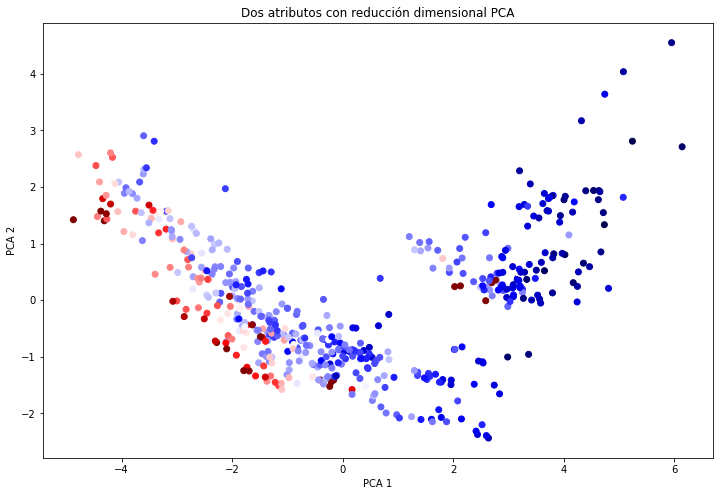

In [15]:
# Escalamos los atributos utilizando la variable boston_columns que dejamos preparada al principio
atributos_scaled = preprocessing.StandardScaler().fit_transform(boston_columns.drop(["CHAS"], axis = 1))

# Calculamos los valores de una matriz con 2 componentes resultantes del dataset y le añadimos las respuestas.
pca_2 = PCA(n_components = 2).fit_transform(atributos_scaled)
pca_2_pd = pd.DataFrame(data = np.c_[pca_2, boston_target], columns = ["PCA 1", "PCA 2"] + ["MEDV"])

# Graficamos utilizando plt.scatter y coloreando con los valores de las respuestas
plt.scatter(x = pca_2_pd["PCA 1"], y = pca_2_pd["PCA 2"], c = pca_2_pd["MEDV"], cmap = "seismic")

# Etiquetamos la gráfica
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Dos atributos con reducción dimensional PCA")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
<ul>
    <li>Repetid la reducción de dimensionalidad, pero en este caso usando TSNE.  Podéis encontrar más información sobre este algoritmo en el link: <a href="https://distill.pub/2016/misread-tsne">https://distill.pub/2016/misread-tsne/</a></li>
    <li>Igual que antes, generad un gráfico con el resultado del TSNE en el que se muestre, en función de los valores de las 2 nuevas dimensiones en los ejes x e y, el valor de la respuesta MEDV usando una escala de colores.</li>
</ul>

<hr>
Sugerencia: no es necesario que programéis el algoritmo TSNE, podéis usar la implementación disponible en la librería de "scikit-learn".<br>
Sugerencia: a parte de especificar el número de componentes, probad de usar el parámetro "perplexity".<br>
Sugerencia: para el gráfico, podéis usar el scatter plot de matplotlib con el parámetro "c", que indica el color de los puntos, igual a la variable objetivo.
</div>

Repetimos por tanto el mismo procedimiento cambiando el algoritmo PCA por el TSNE. También reutilizamos la variable atributos_scaled.

Text(0.5, 1.0, 'Dos atributos con reducción dimensional tsne')

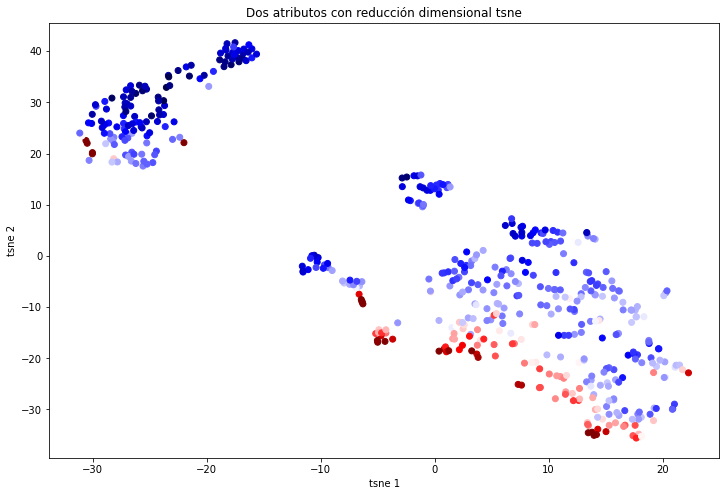

In [16]:
# Reducción dimensional
tsne_2 = TSNE(n_components = 2, perplexity = 30).fit_transform(atributos_scaled)

# Creación de un nuevo dataframe
tsne_2_pd = pd.DataFrame(data = np.c_[tsne_2, boston_target], columns = ["tsne 1", "tsne 2"] + ["MEDV"])

# Graficación de los componentes
plt.scatter(x = tsne_2_pd["tsne 1"], y = tsne_2_pd["tsne 2"], c = tsne_2_pd["MEDV"], cmap = "seismic")

# Etiquetas descriptivas
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("Dos atributos con reducción dimensional tsne")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
<br> Observando los dos gráficos, ¿creéis que ha funcionado bien la reducción de dimensionalidad? ¿Os parece que las 2 nuevas dimensiones consiguen explicar la variación de MEDV y visualizar diferenciadamente precios caros y baratos? ¿Si utilizásemos las 2 nuevas variables para predecir MEDV, con cuál de los dos métodos de reducción de dimensionalidad creéis que obtendríamos los mejores resultados?
    
¿Por qué obtenemos resultados tan diferentes con los dos métodos?
</div>

Sin duda ambos algoritmos han sido capaces de distinguir varios grupos y aislarlos, aunque al tratarse de dos argumentos abstractos, es complicado establecer relaciones entre ellos que expliquen los grupos.

Tan sólo a raíz de la imagen, se puede observar que existen diferencias en la separación de los grupos. Si bien en ambas gráficas se puede observar que el grupo azul oscuro (hipóteticamente correspondería a los baratos según el mapa de color seismic) está mucho más aislado que el grupo rojo (los caros), en la resultante de la reducción dimensional con tsne, el grupo de viviendas caras parece estar mucho más definido respecto a un grupo de precios medios. De ahí que concluyamos que la reducción por tsne posiblemente aportara un modelo más preciso. Aun así, es complicado de decir tan sólo a partir de dos variables abstractas.

# 4. Entrenamiento y test (4 puntos)

En este último ejercicio se trata de aplicar un método de aprendizaje supervisado, concretamente el Random Forest para regresión, para predecir la mediana del precio de cada zona y evaluar la precisión obtenida con el modelo. Para eso usaremos:
<ul>
    <li>El conjunto de datos original con todos los atributos</li>
    <li>El conjunto de datos reducido a sólo 2 atributos con PCA</li>
    <li>El conjunto de datos reducido a sólo 2 atributos con TSNE</li>
</ul>
<br>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Usando el conjunto de datos original:
    
<ul>
    <li>Dividid el dataset en train y test.</li>
    <li>Definid un modelo Random Forest (fijando n_estimators=10 para mantener el modelo simple).</li>
    <li>Aplicad validación cruzada con el modelo definido y el dataset de train (con cv=5 ya es suficiente).</li>
    <li>Como métrica para cuantificar el error del modelo, utilizad tanto R2 (coeficiente de determinación) como MAE (la media del error absoluto) separadamente</li>
    <li>Calculad la media y la desviación standard del error obtenido en cada caso.</li>
</ul>
    
<hr>
Sugerencia: para separar entre train y test podéis usar 'train_test_split' de sklearn.<br>
Sugerencia: para entrenar un modelo random forest podéis usar 'RandomForestRegressor' de sklearn.<br>
Sugerencia: para aplicar validación cruzada podéis usar 'cross_val_score' de sklearn, y modificar su parámetro 'scoring' si fuese necesario.<br>
</div>

Para ejecutar estas tareas, vamos a importar el paquete statistics, que nos facilitará el cálculo de las medias y las desviaciones estándar.

Por otra parte, el procedimiento es bastante claro:

1. Separación en conjunto de entrenamiento y de test
2. Creación y entrenamiento del modelo.
3. Con el modelo entrenado, evaluamos cómo se comporta en la predicción de las respuestas del conjunto de entrenamiento.
4. Mostramos los resultados por pantalla

In [140]:
# Importamos statistics
import statistics

# Establecemos una semilla para la aleatoriedad de train_test_split
np.random.seed(1300)

# En el conjunto de datos original no estandarizamos los atributos dado que no es necesario y de hecho puede afectar a los
# resultados. Es importante indicar que esta va a ser la única diferencia con respecto a los dos modelos siguientes, que sí
# que estarán estandarizados por ser un paso necesario antes de la aplicación de los algoritmos de reducción dimensional.
# Por otra parte, sí que eliminamos el atributo CHAS, que tampoco estará en los dos modelos restantes.
x_train, x_test, y_train, y_test = train_test_split(boston_columns.drop(["CHAS"], axis = 1), boston_target.values.ravel(), 
                                                    train_size = 0.7, test_size = 0.3)

# Creamos el modelo y lo entrenamos
regressor = RandomForestRegressor(n_estimators = 10)
rforest_model_ori = regressor.fit(x_train, y_train)

# Generamos las tres métricas de evaluación
cross_val_result = cross_val_score(rforest_model_ori, x_train, y_train)
mae_result = cross_val_score(rforest_model_ori, x_train, y_train, scoring = 'neg_mean_absolute_error')
r2_result = cross_val_score(rforest_model_ori, x_train, y_train, scoring = 'r2')

# Utilizando la impresión en pantalla, calculamos las medias y desviaciones estándar
print("Para los casos con el conjunto de datos original obtenemos los siguientes resultados: \n")
print("La media resultante de la validación cruzada es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(cross_val_result), statistics.stdev(cross_val_result)))
print("La media resultante de la media del error absoluto es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(mae_result), statistics.stdev(mae_result)))
print("La media resultante del coeficiente de determinación es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(r2_result), statistics.stdev(r2_result)))

Para los casos con el conjunto de datos original obtenemos los siguientes resultados: 

La media resultante de la validación cruzada es 0.77, mientras que su desviación estándar es 0.07
La media resultante de la media del error absoluto es -2.70, mientras que su desviación estándar es 0.25
La media resultante del coeficiente de determinación es 0.82, mientras que su desviación estándar es 0.07


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Repetid el mismo procedimiento que en el ejercicio anterior con el dataset reducido a 2 dimensiones con PCA.
</div>

In [142]:
np.random.seed(1300)
# Entrenamiento reutilizando el modelo pca_2 anterior
x_train, x_test, y_train, y_test = train_test_split(pca_2, boston_target.values.ravel(), 
                                                    train_size = 0.7, test_size = 0.3)

# Generación y entrenamiento del modelo
regressor = RandomForestRegressor(n_estimators = 10)
rforest_model_pca = regressor.fit(x_train, y_train)

# Validaciones
cross_val_result = cross_val_score(rforest_model_pca, x_train, y_train)
mae_result = cross_val_score(rforest_model_pca, x_train, y_train, scoring = 'neg_mean_absolute_error')
r2_result = cross_val_score(rforest_model_pca, x_train, y_train, scoring = 'r2')

# Impresión de resultados en pantalla
print("Para los casos con el conjunto de datos PCA obtenemos los siguientes resultados: \n")
print("La media resultante de la validación cruzada es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(cross_val_result), statistics.stdev(cross_val_result)))
print("La media resultante de la media del error absoluto es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(mae_result), statistics.stdev(mae_result)))
print("La media resultante del coeficiente de determinación es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(r2_result), statistics.stdev(r2_result)))

Para los casos con el conjunto de datos PCA obtenemos los siguientes resultados: 

La media resultante de la validación cruzada es 0.52, mientras que su desviación estándar es 0.20
La media resultante de la media del error absoluto es -4.48, mientras que su desviación estándar es 0.65
La media resultante del coeficiente de determinación es 0.49, mientras que su desviación estándar es 0.21


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Repetid el mismo procedimiento que en el ejercicio anterior con el dataset reducido a 2 dimensiones con TSNE.
</div>

In [143]:
np.random.seed(1300)
# Entrenamiento reutilizando el modelo tsne_2 anterior
x_train, x_test, y_train, y_test = train_test_split(tsne_2, boston_target.values.ravel(), 
                                                    train_size = 0.7, test_size = 0.3)

# Generación y entrenamiento del modelo
regressor = RandomForestRegressor(n_estimators = 10)
rforest_model_tsne = regressor.fit(x_train, y_train)

# Validaciones
cross_val_result = cross_val_score(rforest_model_tsne, x_train, y_train)
mae_result = cross_val_score(rforest_model_tsne, x_train, y_train, scoring = 'neg_mean_absolute_error')
r2_result = cross_val_score(rforest_model_tsne, x_train, y_train, scoring = 'r2')

# Impresión de resultados en pantalla
print("Para los casos con el conjunto de datos TSNE obtenemos los siguientes resultados: \n")
print("La media resultante de la validación cruzada es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(cross_val_result), statistics.stdev(cross_val_result)))
print("La media resultante de la media del error absoluto es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(mae_result), statistics.stdev(mae_result)))
print("La media resultante del coeficiente de determinación es {:.2f}, mientras que su desviación estándar es {:.2f}"
      .format(statistics.mean(r2_result), statistics.stdev(r2_result)))

Para los casos con el conjunto de datos TSNE obtenemos los siguientes resultados: 

La media resultante de la validación cruzada es 0.73, mientras que su desviación estándar es 0.14
La media resultante de la media del error absoluto es -3.26, mientras que su desviación estándar es 0.62
La media resultante del coeficiente de determinación es 0.73, mientras que su desviación estándar es 0.12


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong><br>
¿Con qué datos ha funcionado mejor? ¿Tiene sentido? ¿Cuadra con los resultados que hemos visto en el ejercicio 3?
</div>

Entendemos que el modelo original es el mejor porque los resultados de la validación cruzada y del coeficiente de determinación son mejores y menos dispersos, la media del error absoluto menor y también menos dispersa. 

Es complicado entender a qué se deben estos resultados, pero entendemos que, si bien cuadra con lo visto en el ejercicio 3 en tanto que la reducción dimensional por tsne ha sido más efectiva que la realizada por PCA, la diferencia entre el modelo con el conjunto original de datos y el de tsne es demasiado amplia. Es altamente probable que la pérdida de información generada durante la reducción dimensional haya sido demasiada, y que en caso de ser esto una situación del mundo real y no del académico, hubiera que ajustar los parámetros del tsne para intentar conseguir resultados más eficientes y precisos. 

Como este no es el caso, vamos a continuar con el modelo generado a partir de los datos originales por ser el más exacto.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Con el mejor modelo que hayáis obtenido:
    
<ul>
  <li>Generad predicciones sobre el dataset de test.</li>
  <li>Calculad la precisión de las predicciones obtenidas (R2 y MAE).</li>
</ul>
 
<hr>
Sugerencia: para calcular R2 y MAE podéis usar las funciones dentro del módulo "metrics" de sklearn.
</div>

In [141]:
np.random.seed(1300)
# Volvemos a generar la separación para recuperar la del conjunto de datos original. Al haber indicado una semilla,
# estas serán las mismas
x_train, x_test, y_train, y_test = train_test_split(boston_columns.drop(["CHAS"], axis = 1), boston_target.values.ravel(), 
                                                    train_size = 0.7, test_size = 0.3)

# Predecimos los resultados a partir del conjunto de test
y_pred = rforest_model_ori.predict(x_test)

# Calculamos las métricas de precisión indicadas
mae_result = mean_absolute_error(y_test, y_pred)
r2_result = r2_score(y_test, y_pred)

# Imprimimos los resultados en pantalla
print("El resultado de aplicar mae a las predicciones con el modelo original es: {:.2f}".format(mae_result))
print("El resultado de aplicar R2 a las predicciones con el modelo original es: {:.2f}".format(r2_result))

El resultado de aplicar mae a las predicciones con el modelo original es: 2.28
El resultado de aplicar R2 a las predicciones con el modelo original es: 0.88


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong><br>
¿Cuál de las dos métricas propuestas para evaluar los modelos (R2 o MAE) utilizaríais para explicar lo bueno que es el modelo a un ejecutivo de una inmobiliaria? ¿Y para explicarlo a un analista matemático de la misma compañía? Por qué?  
</div>

A un ejecutivo le explicaría cómo funciona el error absoluto medio. Si bien es mucho más fácil comprender que en r2 cuanto más cercano a 1 mejor y cuanto más cercano a 0 peor, no creo que una simpleza de tal calibre fuera un buen indicativo de un trabajo bien hecho. Así que en el proceso de explicar cómo funciona cada una de las métricas, es mucho más sencillo de comprender el error absoluto medio como una forma de calcular cuánto se ha distanciado el modelo de los valores reales. Sería importante mostrar que 2.28 es un valor razonablemente bueno (+/- 2280 dólares en el valor predicho para un inmueble) y que el modelo es eficaz.

Por otra parte, a un matemático le enseñaría el resultado del coeficiente de determinación. Le explicaría que es el resultante de la varianza de los valores predichos dividida por la varianza de los valores reales. Es decir, que el modelo explicaría en un 88% el comportamiento de la variable real.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
El modelo random forest depende de muchos parámetros. En este ejercicio sólo hemos especificado el número de árboles (n_estimators) y hemos dejado que usara el resto de parámetros por defecto. Dos parámetros muy útiles en los random forest (y en cualquier modelo que use árboles) son el max_depth y el min_samples_split. Estos parámetros ayudan a controlar el overfitting.
    
Entrenad los modelos anteriores usando diferentes combinaciones de los parámetros:<ul>
  <li>n_estimators</li>
  <li>max_depth</li>
  <li>min_samples_split</li>
</ul>
con el objetivo de encontrar la combinación de parámetros que da los mejores resultados en el conjunto de datos de entrenamiento.

Para el modelo con la mejor combinación de parámetros, calculad las métricas de error (R2 y MAE) en el conjunto de datos de test.
</div>

In [139]:
np.random.seed(1300)
# Volvemos a generar la separación para recuperar la del conjunto de datos original. Al haber indicado una semilla,
# estas serán las mismas
x_train, x_test, y_train, y_test = train_test_split(boston_columns.drop(["CHAS"], axis = 1), boston_target.values.ravel(), 
                                                    train_size = 0.7, test_size = 0.3)

# Creamos el modelo y lo entrenamos
regressor = RandomForestRegressor(n_estimators = 15, max_depth = 13, min_samples_split = 7)
rforest_model_ori = regressor.fit(x_train, y_train)

# Predecimos los resultados a partir del conjunto de test
y_pred = rforest_model_ori.predict(x_test)

# Calculamos las métricas de precisión indicadas
mae_result = mean_absolute_error(y_test, y_pred)
r2_result = r2_score(y_test, y_pred)

# Imprimimos los resultados en pantalla
print("El resultado de aplicar mae a las predicciones con el modelo original es: {:.2f}".format(mae_result))
print("El resultado de aplicar R2 a las predicciones con el modelo original es: {:.2f}".format(r2_result))

El resultado de aplicar mae a las predicciones con el modelo original es: 2.19
El resultado de aplicar R2 a las predicciones con el modelo original es: 0.90


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong><br>
¿Habéis conseguido mejorar el modelo? ¿Cuál ha sido el impacto de variar cada parámetro en la precisión del modelo?  
</div>

Repitiendo el código y cambiandolos parámetros una y otra vez, hemos conseguido mejorar los resultados ligeramente, pasando de un R2 con valor 0.88 a un 0.02 más, es decir 0.90. 

En cuando al error absoluto medio, lo hemos bajado un 0.09, un valor ligeramente inferior.

Hemos podido ver que la profundidad máxima llega un punto en el que no tiene sentido tocarla, una vez que el árbol ha crecido todo lo que tenía que crecer, no tiene sentido seguir subiendo el valor del parámetro. Hemos probado con los valores entre 1 y 17 y sin duda 13 era el óptimo.

El número de estimadores ha sido el que más ha hecho variar los resultados, siendo la base que después se ha podido matizar con el número mínimo de muestras para hacer otra división. Con un conocimiento mayor del dataset podríamos haber conseguido indicadores aún mejores para elegir mejores valores para los parámetros. Otra opción habría sido tirar de generación aleatoria de números para encontrar el modelo más acertado posible.

Hemos decidido hacer pruebas aleatorias de números en lugar de automatizar una búsqueda de los valores "óptimos" para comprender realmente cómo estos valores afectaban a los resultados (por ejemplo, de haber sido automático no habríamos entendido que no tenía sentido seguir probando valores para la profundidad máxima). 

Sin duda estos cambios destapan preguntas sobre el sobre-entrenamiento de un modelo, lo que con un conocimiento extensivo se podría convertir en una herramienta para controlarlo.